Due to the very long run time through ACCRE, the code below is not run, but I will insert the files containing the results here and also in the github repository. 

In [6]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.optim as optim
import random

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt

import os
from os import walk




I used the package of PyTorch for both this and the convolutional neural network.

In [ ]:
transformation = transforms.Compose([
        transforms.Resize([54,85]),
        transforms.ToTensor()
    ])

ampt_datasets = torchvision.datasets.ImageFolder(root= '/store/user/anderht3/ampt_visuals',transform = transformation)


train_size = 7990
test_size = 1998

trainsampt, testsampt = torch.utils.data.random_split(ampt_datasets, [train_size,test_size])


batchsize = 100

trainloader = torch.utils.data.DataLoader(trainsampt, batch_size=batchsize,
                                             shuffle=True)
testloader = torch.utils.data.DataLoader(testsampt, batch_size=len(testsampt),
                                             shuffle=True)


dataiter = iter(testloader)
images, labels = dataiter.next()

#print(images.shape)

#print(images[0].shape)
#print(labels[7].item())

batch_size = 512 # Try varying this. Its on the large side for minibatches.
data_loader_train = torch.utils.data.DataLoader(trainloader, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(testloader, batch_size=len(testloader), shuffle=False)

The batchsize as well as the number of pixels that the images are resized to vary with each trial performed.

In [ ]:
def imshow(img, title):

    plt.figure(figsize=(batchsize * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))

    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

    return images, labels

images, labels = show_batch_images(trainloader)

In [ ]:
class Base_Model(nn.Module):
    def __init__(self):
        super(Base_Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(13770, 12000),  # 28 x 28 = 784 pixels
            nn.BatchNorm1d(12000),
            nn.ReLU(),
            nn.Linear(12000, 8400),
            nn.BatchNorm1d(8400),
            nn.ReLU(),
            nn.Linear(8400, 7200),
            nn.BatchNorm1d(7200),
            nn.ReLU(),
            nn.Linear(7200, 4800),
            nn.BatchNorm1d(4800),
            nn.ReLU(),
            nn.Linear(4800, 2400),
            nn.BatchNorm1d(2400),
            nn.ReLU(),
            nn.Linear(2400, 1200),
            nn.BatchNorm1d(1200),
            nn.ReLU(),
            nn.Linear(1200, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Linear(600, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )


def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
#         return x
        return x


The model used has seven layers with relu and batch normalization.

In [ ]:
model = Base_Model()
#print(model)

def train_batch(model, x, y, optimizer, loss_fn):
    #add back in optimizer
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()

##### Iterate over epochs and all batches of data
def train(model, train_loader , test_loader , optimizer, loss_fn, epochs=200):
    #add back in optimizer
    losses = list()
    losses_test = list()
    accuracy = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in train_loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        for x , y in test_loader:
            y_predict = model.forward(x)
            losst = loss_fn(y_predict, y)

            losses_test.append(losst.data.item())

            accuracy.append(error(y,y_predict))
#         print("Epoch: ", e+1)
#         print("Batches: ", batch_index)

    return losses , losses_test, accuracy, epochs

def error(label,y):
  count = 0
  for i in range(len(y)):
    max = y[i][0]
    found = 0
    for j in range(len(y[i])):
      if(y[i][j] > max):
        max = y[i][j]
        found = j

    if(label[i] == found):
      count +=1
  return (count/(len(y)))


def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict

#####
def test(model, test_loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in test_loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector


def run(data_loader_train, data_loader_test , model_to_test , weight_decay):


    # Define the hyperparameters
    learning_rate = 1e-3
    model = model_to_test()

    # Initialize the optimizer with above parameters

    # Initialize the optimizer with above parameters
    optimizer = optim.Adam(model.parameters(), lr=learning_rate , weight_decay = weight_decay)

    # Define the loss function
    loss_fn =   torch.nn.CrossEntropyLoss() # mean squared error

    # Train and get the resulting loss per iteration
    loss , loss_test, accuracy, epoch = train(model=model, train_loader=data_loader_train , test_loader = data_loader_test,
                 optimizer=optimizer, loss_fn=loss_fn)

    # Test and get the resulting predicted y values
    y_predict = test(model=model, test_loader=data_loader_test)

    return loss , loss_test , y_predict, accuracy, epoch



def plot_loss(losses_train,loss_test, show=True):
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    ax = plt.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    plt.plot(x_loss, losses_train)


    a = list(range(len(loss_test)))
    const = round(len(losses) / len(loss_test))
    b = [(i+1)*const for i in a]

    plt.plot(b,loss_test)

    if show:
        plt.show()

    plt.savefig("Loss_large_set.png")
    plt.close()

def plot_accuracy(accuracy,epochs):
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    ax = plt.axes()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    x_loss = list(range(epochs))
    plt.plot(x_loss, accuracy)

    plt.savefig("Accuracy_large_set.png")
    plt.close()

                                                    

In [ ]:
losses, loss_test, y_predict, accuracy, epoch = run(data_loader_train=trainloader, data_loader_test=testloader ,
                        model_to_test = Base_Model,  weight_decay = 0)


plot_accuracy(accuracy,epoch)
print("Final accuracy:", accuracy[-1:])


plot_loss(losses,loss_test)
print("Final loss:", loss_test[-1:])



This produced two graphs of the loss and the accuracy of the trial runs. The example shown below is from epochs = 15, batchsize = 20, and pixels = 54x85 with ~4000 figures.

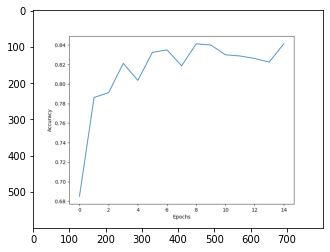

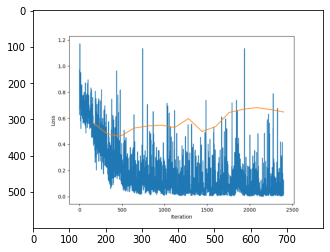

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/Accuracy_Fig_15 (1).png')
img1 = mpimg.imread('/content/Loss_Fig_15 (1).png')
imgplot = plt.imshow(img)
plt.show()
imgplot1 = plt.imshow(img1)
plt.show()

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


transformation = transforms.Compose([
        transforms.Resize([54,85]),
        transforms.ToTensor()
    ])

ampt_datasets = torchvision.datasets.ImageFolder(root= '/store/user/anderht3/ampt_visuals/',transform = transformation)


train_size = 7990
test_size = 1998


trainsampt, testsampt = torch.utils.data.random_split(ampt_datasets, [train_size,test_size])

batchsize = 100

dataloaders = {'train': torch.utils.data.DataLoader(trainsampt, batch_size=batchsize,
                                             shuffle=True),
              'test': torch.utils.data.DataLoader(testsampt, batch_size=len(testsampt),
                                             shuffle=True)}
dataset_sizes = {'train': len(trainsampt),
                 'test': len(testsampt)}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

                               
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


Model = torchvision.models.resnet50(pretrained=True)

for param in Model.parameters():
    param.requires_grad = False

Model.fc = nn.Linear(2048,2)


num_ftrs = Model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

Model = Model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model_ft = train_model(Model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=50)
                                               

The code above is a basic CNN set up that was used in a previous homework. Similar to the NN, it depends on batchsize, number of epochs, number of pixels, and number of images used. The results will not be included in this file since I have the output as a text file, but it will be included int he github repository.